In this notebook, we are going to fine tune the YOLOS model for a custom object detection task. The task is to recognize plastic pollutants in images of waterbodies. We will be using the `kili-technology/plastic_in_river` dataset from HuggingFace.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/huggingface/datasets.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.2/346.2 kB 12.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import os
import json
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from datasets import load_dataset_builder, get_dataset_split_names, load_dataset
from transformers import YolosImageProcessor, YolosForObjectDetection, AutoModelForObjectDetection

# Data

In [3]:
dataset_name = 'kili-technology/plastic_in_river'

In [4]:
ds_builder = load_dataset_builder(dataset_name)
print(ds_builder.info.description)
print(ds_builder.info.features)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1476: FutureWarning: The repository for kili-technology/plastic_in_river contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kili-technology/plastic_in_river
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major


    This dataset contains photos of rivers on which there may be waste. The waste items are annotated
    through bounding boxes, and are assigned to one of the 4 following categories: plastic bottle, plastic bag,
    another plastic waste, or non-plastic waste. Note that some photos may not contain any waste.

{'image': Image(decode=True, id=None), 'litter': Sequence(feature={'label': ClassLabel(names=['PLASTIC_BAG', 'PLASTIC_BOTTLE', 'OTHER_PLASTIC_WASTE', 'NOT_PLASTIC_WASTE'], id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None)}, length=-1, id=None)}


In [5]:
get_dataset_split_names(dataset_name)

['train', 'test', 'validation']

In [6]:
ds_train = load_dataset(path=dataset_name, split='train[:1000]',
                      trust_remote_code=True, streaming=False)
ds_val = load_dataset(path=dataset_name, split='validation[:100]',
                      trust_remote_code=True, streaming=False)

Generating train split:   0%|          | 0/3407 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/425 [00:00<?, ? examples/s]

In [7]:
print(ds_train)
print(ds_val)

Dataset({
    features: ['image', 'litter'],
    num_rows: 1000
})
Dataset({
    features: ['image', 'litter'],
    num_rows: 100
})


The bounding box present in the dataset follows the convention (x_cen, y_cen, width, height). This is the same convention as required for the YOLOS model.

The output space consists of 4 labels.

In [8]:
class_names = ds_val.info.features['litter'].feature['label'].names
class_names

['PLASTIC_BAG', 'PLASTIC_BOTTLE', 'OTHER_PLASTIC_WASTE', 'NOT_PLASTIC_WASTE']

In [9]:
demo_datarow = ds_val[1]

In [10]:
def plot_datarow(datarow):
    image = datarow['image']
    litter = datarow['litter']

    # Get image dimensions to rescale the bounding box
    img_w, img_h = image.size

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for label_id, bbox in zip(litter['label'], litter['bbox']):
        # Convert from dimensionless to pixel units
        scaled_bbox = np.asarray(bbox) * np.array([img_w, img_h, img_w, img_h])
        ax.add_patch(plt.Rectangle(xy=(scaled_bbox[0] - scaled_bbox[2] / 2, scaled_bbox[1] - scaled_bbox[3] / 2),
                                   width=scaled_bbox[2],
                                   height=scaled_bbox[3],
                                   fill=False, color='yellow'))

        # Add class label
        ax.text(scaled_bbox[0] - scaled_bbox[2] / 2,
                scaled_bbox[1] - scaled_bbox[3] / 2,
                str(class_names[label_id]), verticalalignment='bottom')

    plt.axis('off')
    plt.show()


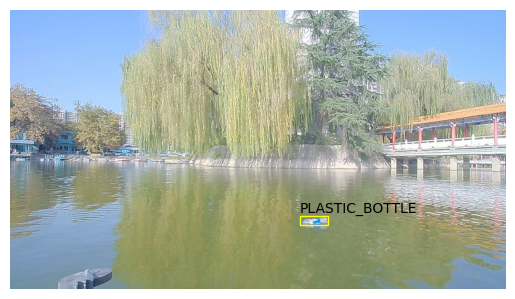

In [11]:
plot_datarow(demo_datarow)

# YOLOS model

In [12]:
model_name = "hustvl/yolos-small"

In [13]:
# Now let's check what YOLOS model predicts on the same image.
# First let's load the model
image_processor = YolosImageProcessor.from_pretrained(model_name,
                                                      size={"shortest_edge": 512, "longest_edge": 864})
model = YolosForObjectDetection.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/123M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
# Preprocess the image
pixel_values = image_processor.preprocess(demo_datarow['image'], return_tensors='pt',
                                          size={"height": 512, "width": 864}).pixel_values
pixel_values.shape

torch.Size([1, 3, 512, 864])

In [15]:
# Get model predictions
with torch.no_grad():
    outputs = model(pixel_values, output_attentions=False)

Error during conversion: ValueError('Queue is full! Please try again.')


model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

In [16]:
# Only keep high probability detections
probas = outputs.logits.softmax(dim=-1)[0, :, :-1]
keep = probas.max(dim=-1).values > 0.8

In [17]:
# Rescale bounding boxes to original image size
target_sizes = torch.tensor(demo_datarow['image'].size[::-1]).unsqueeze(0)  # add batch dimension
post_processed_outputs = image_processor.post_process(outputs,
                                                      target_sizes=target_sizes)

bboxes_scaled = post_processed_outputs[0]['boxes']

`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


In [18]:
def plot_yolos_results(image, probas, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for p, (xmin, ymin, xmax, ymax) in zip(probas, bboxes):
        ax.add_patch(plt.Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, fill=False, color='yellow'))

        class_idx = p.argmax()
        class_label = model.config.id2label[class_idx.item()]
        ax.text(xmin, ymin, f'{class_label}: {p[class_idx]:.2f}')
    plt.axis('off')
    plt.show()

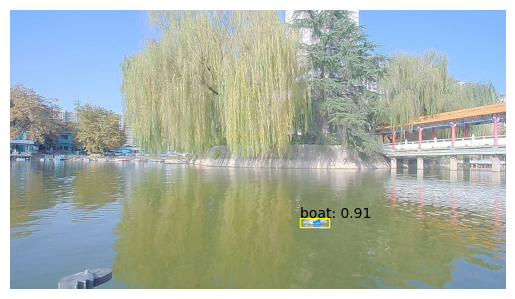

In [19]:
plot_yolos_results(demo_datarow['image'], probas[keep], bboxes_scaled[keep])

The model hilariously predicts floating plastic debris as `boats`.

# Write as COCO annotations

To being fine-tuning the model, we need to first make sure that the inputs to the model (image + annotations) are being provided in the correct format. For more details on the COCO annotation format refer to [this](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/md-coco-overview.html) page.

In [20]:
!rm -r /content/coco

rm: cannot remove '/content/coco': No such file or directory


In [21]:
categories = []
for id, class_name in enumerate(class_names):
    this_category_entry = {"supercategory": "debris", "id": id, "name": class_name}
    categories.append(this_category_entry)


def write_to_disk_in_coco(dataset, coco_path: str, split: str,
                          start_index: int = 0):

    # Create images and annotation paths
    os.makedirs(os.path.join(coco_path, "images"), exist_ok=True)
    os.makedirs(os.path.join(coco_path, "annotations"), exist_ok=True)

    images = []
    annotations = []

    annot_id = 0
    for i, datarow in enumerate(dataset):
        # Save image to disk
        fname = os.path.join("images", f'img_{start_index + i}.png')
        datarow['image'].save(os.path.join(coco_path, fname))

        # Get image dimensions
        width, height = datarow['image'].size

        # Image blob
        this_image_blob = {
            "file_name": fname,
            "height": height,
            "width": width,
            "id": start_index + i,
        }

        images.append(this_image_blob)

        # Write annotations in COCO format.
        for label, bbox in zip(datarow['litter']['label'], datarow['litter']['bbox']):
            # Scale bbox to pixel sizes.
            bbox_pixel_units = np.asarray(bbox) * np.asarray([width, height, width, height], dtype=np.float32)
            this_annotation_blob = {
                "id": annot_id,
                "image_id": start_index + i,
                "category_id": label,
                # We need (top_left_x, top_left_y, width, height) for COCO
                "bbox": [bbox_pixel_units[0] - bbox_pixel_units[2] / 2,
                         bbox_pixel_units[1] - bbox_pixel_units[3] / 2,
                         bbox_pixel_units[2], bbox_pixel_units[3]
                         ],
                "area": bbox_pixel_units[2] * bbox_pixel_units[3],
                "iscrowd": 0,
            }

            annot_id += 1
            annotations.append(this_annotation_blob)

    coco_json_dict = {
        "info": None,
        "licenses": None,
        "images": images,
        "annotations": annotations,
        "categories": categories,
    }

    # Save to json
    with open(os.path.join(coco_path, "annotations", f"{split}_labels.json"), 'w') as fp:
        json.dump(coco_json_dict, fp, indent=2)


In [22]:
# Save train to COCO dataset
write_to_disk_in_coco(dataset=ds_train, coco_path="/content/coco",
                      split="train", start_index=0)

In [23]:
# Save val to COCO format. Since we are storing all the images
# in the same location, we need to provide start_index equal to the
# length of the training set
write_to_disk_in_coco(dataset=ds_val, coco_path="/content/coco", split='val',
                      start_index=len(ds_train))

# Pytorch dataset

In [24]:
from torchvision.datasets import CocoDetection

In [25]:
class CustomCocoDetection(CocoDetection):
    def __init__(self, coco_root, image_processor, train=True):
        annot_file = os.path.join(coco_root, "annotations", "train_labels.json" if train else "val_labels.json")
        super().__init__(root=coco_root, annFile=annot_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        image_id = self.ids[idx]

        # For more details on the annotations format for YOLOS refer to this
        # https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/yolos#transformers.YolosImageProcessor
        annots = {"image_id": image_id, 'annotations': target}

        encoding = self.image_processor.preprocess(images=img, annotations=annots,
                                                   return_tensors="pt", do_convert_annotations=True,
                                                   size={"height": 512, "width": 864})

        # For the input signature for the YOLOS forward function, please refer
        # to https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/yolos#transformers.YolosImageProcessor
        pixel_values = encoding.pixel_values.squeeze()  # remove batch dimension
        labels = encoding["labels"][0]  # remove batch dimension

        return pixel_values, labels

In [26]:
train_dataset = CustomCocoDetection(coco_root="/content/coco",
                                    image_processor=image_processor, train=True)
val_dataset = CustomCocoDetection(coco_root="/content/coco",
                                  image_processor=image_processor, train=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


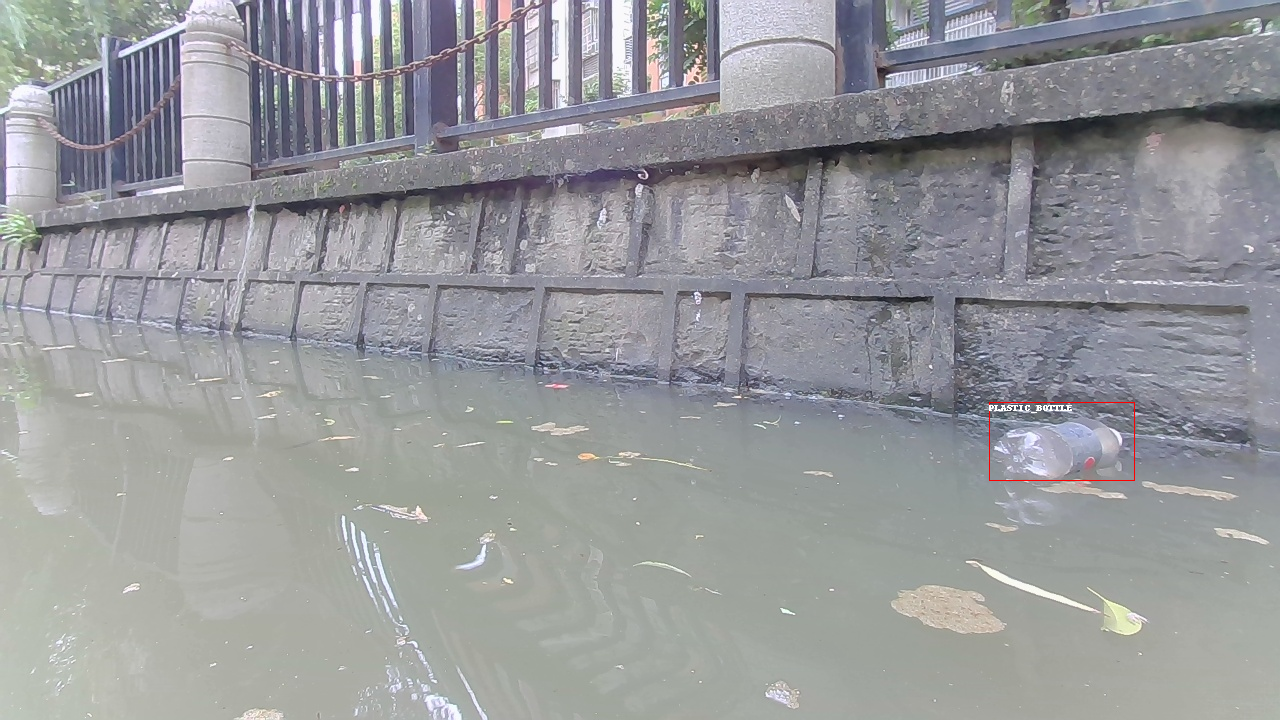

In [27]:
# image_ids = train_dataset.coco.getImgIds()
image_id = 4  # Choose random image.

# Load image
image = train_dataset.coco.loadImgs(ids=image_id)[0]
image = Image.open(os.path.join("/content/coco", image["file_name"]))

# Load annotations
annots = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

# Create id to label from COCO categories
cats = train_dataset.coco.cats
id2label = {k: v['name'] for k, v in cats.items()}

for annot in annots:
    box = annot['bbox']
    class_idx = annot['category_id']
    x, y, w, h = tuple(box)

    # To pass to PIL (topleft_x, topleft_y, bottomright_x, bottomright_y)
    draw.rectangle((x, y, x+w, y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image

# Pytorch Dataloader

In [28]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 1000
Number of validation examples: 100


In [29]:
from torch.utils.data import DataLoader

# Since the images after preprocess can be of different sizes, trying to do the
# following: train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# will results in the error: RuntimeError: stack expects each tensor to be equal size, but got [2] at entry 0 and [1] at entry 1
# To circumvent this, we will pad the images to the largest size present in the batch

def collate_fn(batch):
    # This will be of shape: batch_size x 3 x width x height
    pixel_values = torch.stack([item[0] for item in batch])

    # If processed images were of unequal sizes, then we nedd to do
    # padding of images and also annotations
    # encoding = image_processor.pad(pixel_values, return_tensors="pt")

    labels = [item[1] for item in batch]
    return {'pixel_values': pixel_values, 'labels': labels}

In [30]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn,
                              batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

In [31]:
# Let's inspect a batch
batch = next(iter(train_dataloader))

In [32]:
# According to the forward function inputs, we need labels to be a list of
# dictionaries whose length is equal to the batch size
len(batch['labels'])

1

In [33]:
# Similarly, we need pixel_values as input to the forward function and it should
# have shape: (batch_size x num_channels x height x width)
batch['pixel_values'].size()

torch.Size([1, 3, 512, 864])

In [34]:
# labels (List[Dict] of len (batch_size,), optional) — Labels for computing the bipartite matching loss.
# List of dicts, each dictionary containing at least the following 2 keys: 'class_labels' and
# 'boxes' (the class labels and bounding boxes of an image in the batch respectively).
# The class labels themselves should be a torch.LongTensor of len (number of bounding boxes in the image,)
# and the boxes a torch.FloatTensor of shape (number of bounding boxes in the image, 4).
batch['labels'][0]

{'size': tensor([512, 864]), 'image_id': tensor([948]), 'class_labels': tensor([1]), 'boxes': tensor([[0.9134, 0.8227, 0.0868, 0.0361]]), 'area': tensor([1384.8096]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 720, 1280])}

# Model building

In [35]:
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 36.3 MB/s eta 0:00:00


In [36]:
import pytorch_lightning as pl


class CustomDetectionModel(pl.LightningModule):
    def __init__(self, lr, weight_decay):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained(model_name,
                                                                 num_labels=len(id2label),
                                                                 ignore_mismatched_sizes=True)
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        return outputs

    def yolos_forward(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.yolos_forward(batch, batch_idx)

        self.log("training_loss", loss, prog_bar=True)
        for k, v in loss_dict.items():
            self.log(f"train_{k}", v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.yolos_forward(batch, batch_idx)
        self.log("validation_loss", loss, prog_bar=True)
        for k, v in loss_dict.items():
            self.log(f"validation_{k}", v.item())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                      weight_decay=self.weight_decay)
        return optimizer

In [37]:
# Note that an additional 'no_object_class' label is added by the model, hence the
# output space consists of 5 labels.
custom_model = CustomDetectionModel(lr=2e-5, weight_decay=1e-4)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([5, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Let's sanity check that the custom model we created works correctly
sanity_check_outputs = custom_model(batch['pixel_values'])

Error during conversion: ValueError('Queue is full! Please try again.')


In [39]:
# Since YOLOS consists of 100 detection tokens, the logits will have
# shape: batch_size x 100 x num_classes
sanity_check_outputs['logits'].shape

torch.Size([1, 100, 5])

# Model training

In [40]:
from pytorch_lightning import Trainer

# Idea iteration
trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, accelerator="gpu")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(custom_model, train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.605   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Model evaluation

We will use the validation set to evaluate the performance of the model.

In [46]:
! git clone https://github.com/facebookresearch/detr.git
%cd /content/detr/datasets

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 9.66 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/detr/datasets


In [49]:
import sys
sys.path.insert(0, '/content/detr')

In [50]:
base_ds = val_dataset.coco

In [51]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

custom_model.to(device)
custom_model.eval()

CustomDetectionModel(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosAttention(
              (attention): YolosSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                

In [65]:
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs to the model
    pixel_values = batch['pixel_values'].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    # Forward pass
    outputs = custom_model.model(pixel_values=pixel_values)

    # Get original size of each image
    orig_target_sizes = torch.stack([target['orig_size'] for target in labels], dim=0)
    post_processed_outputs = image_processor.post_process(outputs, orig_target_sizes)

    res = {
        target['image_id'].item(): output for target, output in zip(labels, post_processed_outputs)
    }
    coco_evaluator.update(res)

  0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

# Visualization

In [52]:
custom_model.to(device)
_ = custom_model.eval()

In [111]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def plot_inf_results(image, prob, boxes):
    fig, ax = plt.subplots()
    ax.imshow(image)

    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle(xy=(xmin, ymin),
                                   height=(ymax - ymin),
                                   width=(xmax - xmin),
                                   fill=False, color=c))

        # Get the class label corresponding to this bounding box
        class_idx = p.argmax()
        class_label = f'{id2label[class_idx.item()]}: {p[class_idx]:0.2f}'
        ax.text(xmin, ymin, class_label)
    plt.axis('off')
    plt.show()

def visualize_prediction(image, outputs, threshold=0.8):
    # Get probabilities from logits and only keep significant detections
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
    bboxes_scaled = image_processor.post_process(outputs,
                                                 target_sizes=target_sizes)[0]['boxes']

    plot_inf_results(image, probas[keep], bboxes_scaled)

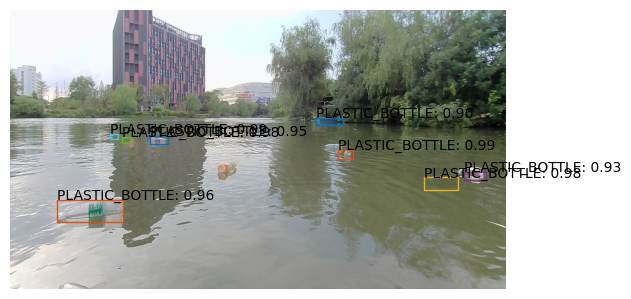

In [120]:
pixel_values, target = val_dataset[57]
pixel_values = pixel_values.unsqueeze(0).to(device)

# model prediction
outputs = custom_model(pixel_values=pixel_values)

image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join("/content/coco", image['file_name']))

visualize_prediction(image, outputs)

# Custom Image

In [123]:
import requests
url = 'https://www.kimointernational.org/wp/wp-content/uploads/2017/12/plastic_bottle_river.jpg'
custom_img = Image.open(requests.get(url, stream=True).raw)

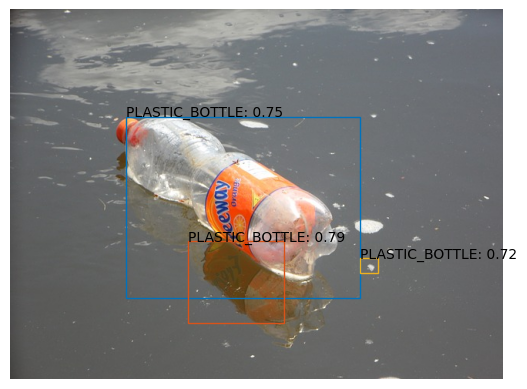

In [126]:
pixel_values = image_processor.preprocess(images=custom_img, return_tensors="pt",
                                          size={"height": 512, "width": 864}).pixel_values
pixel_values = pixel_values.to(device)
outputs = custom_model(pixel_values)

visualize_prediction(custom_img, outputs, threshold=0.7)